In [1]:
# Import libraries
import pandas as pd
import numpy as np
# import torch
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import roc_curve, roc_auc_score
# from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc

from tokenizer.my_tokenizers import SMILES_SPE_Tokenizer

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


# from functions.data_funcs import reset_parameters
# from functions.inference_funcs import find_checkpoint_with_lowest_val_mse

# Load data ######################################################################
validation_data = pd.read_csv('training_data/kmeans_regression/kmeans_regression_validation.csv')
validation_data.columns = ['smiles', 'label']

def encode_data(data, tokenizer):
    encoded_data = []
    for i, row in data.iterrows():
        smiles = row['smiles']
        encoded = tokenizer(smiles, return_tensors='pt')
        encoded_data.append(encoded)
    return encoded_data

def get_tokenizer():
    vocab_file = 'tokenizer/new_vocab.txt'
    splits_file = 'tokenizer/new_splits.txt'
    tokenizer = SMILES_SPE_Tokenizer(vocab_file, splits_file)
    return tokenizer

def get_huggingface_model(model_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.cuda()
    return model

def predict_model(input_ids, attention_mask, model):
    import torch
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs

def get_predictions(encoded_data, model):
    # from tqdm import tqdm
    predictions = []
    # for encoded in tqdm(encoded_data):
    for encoded in encoded_data:
        input_ids = encoded['input_ids'].to('cuda')
        attention_mask = encoded['attention_mask'].to('cuda')
        outputs = predict_model(input_ids, attention_mask, model)
        predictions.append(outputs[0].item())
    return predictions

def get_model_predictions(encoded_data, model_path):#, saving_label):
    classification_data = validation_data.copy()
    for i in range(5):
        full_model_path = f'{model_path}{i+1}'
        model = get_huggingface_model(full_model_path)
        model.eval()
        model.cuda()
        predictions = get_predictions(encoded_data, model)
        # append predictions to classification data
        classification_data[f'pred_{i+1}'] = predictions
    # save predictions
    classification_data['label_classification'] = classification_data['label'].apply(lambda x: 1 if x >= -6 else 0)
    classification_data['mean'] = classification_data[['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5' ]].mean(axis=1)
    # classification_data.to_csv(f'{saving_label}_allpreds.csv', index=False)
    return classification_data

# Function to darken colors
def darken_color(color, amount=0.8):
    c = np.array(color)
    return np.clip(c * amount, 0, 1)

# make plot
def plot_roc_auc(data, saving_label):
    # Create a custom colormap
    oldcmp = plt.get_cmap('Set2')
    newcmp = ListedColormap(oldcmp.colors[:6])
    # Extract the colors from the colormap and darken them
    dark_colors = [darken_color(color) for color in newcmp.colors]
    
    # colors = ['red', 'darkorange', 'green', 'blue', 'purple']
    plt.figure()
    for i in range(5):
        fpr, tpr, thresholds = roc_curve(data['label_classification'], data[f'pred_{i+1}'])
        auc = roc_auc_score(data['label_classification'], data[f'pred_{i+1}'])
        plt.plot(fpr, tpr, color=dark_colors[i], lw=1.5, linestyle='-', label=f'ROC fold {i+1} (AUC = {auc:.3f})')
    fpr, tpr, thresholds = roc_curve(data['label_classification'], data['mean'])
    auc = roc_auc_score(data['label_classification'], data['mean'])
    plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC mean (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=1.2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'{saving_label}_roc-auc.svg', format='svg')


# make plot
def plot_pr_auc(data, saving_label):
    # Create a custom colormap
    oldcmp = plt.get_cmap('Set2')
    newcmp = ListedColormap(oldcmp.colors[:6])
    
    # Extract the colors from the colormap and darken them
    dark_colors = [darken_color(color) for color in newcmp.colors]
    
    plt.figure()
    for i in range(5):
        precision, recall, thresholds = precision_recall_curve(data['label_classification'], data[f'pred_{i+1}'])
        auc = average_precision_score(data['label_classification'], data[f'pred_{i+1}'])
        plt.plot(recall, precision, color=dark_colors[i], lw=1.5, linestyle='-', label=f'PR fold {i+1} (AUC = {auc:.3f})')
    
    precision, recall, thresholds = precision_recall_curve(data['label_classification'], data['mean'])
    auc = average_precision_score(data['label_classification'], data['mean'])
    plt.plot(recall, precision, color='black', lw=2, label=f'PR mean (AUC = {auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.title('Precision-Recall AUC')
    plt.grid(True)
    plt.savefig(f'{saving_label}_pr-auc.svg', format='svg')
    plt.show()



/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/torch/_utils.py:832: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


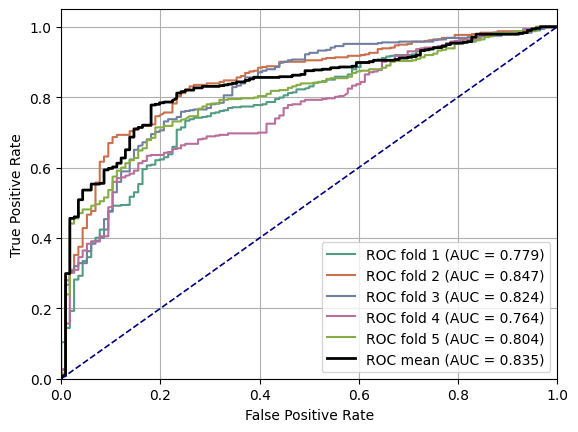

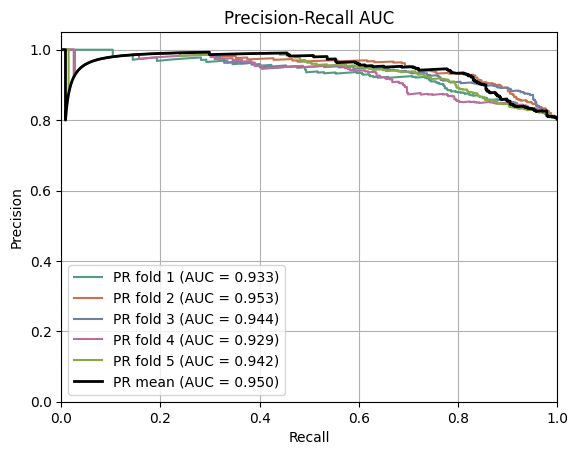

R2 values: [0.3920391391801402]AUROC values: [0.835302819988311]PR AUC values: [0.9498906900673035]
Mean R2: 0.392 +/- 0.000
Mean AUROC: 0.835 +/- 0.000
Mean PR AUC: 0.950 +/- 0.000


In [2]:
from sklearn.metrics import r2_score, auc

### FOR FULL PeptideLM Model ###
r2_values = []
auroc_values = []
pr_auc_values = []

# Define checkpoint path
ckpt_path = f'aaronfeller/PeptideCLM-23.4M-CycPeptMPDB-fold-'
# Load tokenizer
tokenizer = get_tokenizer()
# Encode data
encoded_data = encode_data(validation_data, tokenizer)

# Load checkpoints and evaluate
classification_data = get_model_predictions(encoded_data, model_path=ckpt_path)
# Plot ROC curve
plot_roc_auc(classification_data, f'figures/PeptideCLM-ROC-AUC')
plot_pr_auc(classification_data, f'figures/PeptideCLM-PR-AUC')

# calculate R2 value
r2 = r2_score(classification_data['label'], classification_data['mean'])
r2_values.append(r2)

auroc = roc_auc_score(classification_data['label_classification'], classification_data['mean'])
auroc_values.append(auroc)

# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(classification_data['label_classification'], classification_data['mean'])
pr_auc = auc(recall, precision)
pr_auc_values.append(pr_auc)


print(f'R2 values: {r2_values}'
    f'AUROC values: {auroc_values}'
    f'PR AUC values: {pr_auc_values}')

# calculate mean R2 value and standard deviation
mean_r2 = sum(r2_values) / len(r2_values)
std_r2 = (sum([(r2 - mean_r2) ** 2 for r2 in r2_values]) / len(r2_values)) ** 0.5
print(f'Mean R2: {mean_r2:.3f} +/- {std_r2:.3f}')

# calculate mean AUROC value and standard deviation
mean_auroc = sum(auroc_values) / len(auroc_values)
std_auroc = (sum([(auroc - mean_auroc) ** 2 for auroc in auroc_values]) / len(auroc_values)) ** 0.5
print(f'Mean AUROC: {mean_auroc:.3f} +/- {std_auroc:.3f}')

mean_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
std_pr_auc = (sum([(pr_auc - mean_pr_auc) ** 2 for pr_auc in pr_auc_values]) / len(pr_auc_values)) ** 0.5
print(f'Mean PR AUC: {mean_pr_auc:.3f} +/- {std_pr_auc:.3f}')
